# Clube AM
## Automatizando a coleta de demonstrativos financeiros no Python

### Como automatizar uma análise?

Através de um linguagem de programação é possível criar métodos que permitem automatizar processos, e o mais interessante é a possibilidade de criar scripts que permitam:

- Coletar os dados
- Realizar o tratamento
- Criar cálculos
- Criar gráficos

E tudo isso estar contido dentro de um report, seja HTML ou PDF.

Demonstrações Financeiras Padronizadas
Antes de buscar os dados, devemos entender a sua fonte. Os demonstrativos das empresas listadas na B3 são reunidos no que é conhecido como Demonstrações Financeiras Padronizadas, um documento de encaminhamento periódico que as empresas realizam para a CVM.

As demonstrações financeiras devem ser enviadas e elaboradas de acordo com as regras contábeis das instruções da CVM.

Entre os demonstrativos enviados de acordo com a DFP, temos:

- Balanço Patrimonial Ativo (BPA)
- Balanço Patrimonial Passivo (BPP)
- Demonstração de Fluxo de Caixa - Método Direto (DFC-MD)
- Demonstração de Fluxo de Caixa - Método Indireto (DFC-MI)
- Demonstração das Mutações do Patrimônio Líquido (DMPL)
- Demonstração de Resultado Abrangente (DRA)
- Demonstração de Resultado (DRE)
- Demonstração de Valor Adicionado (DVA)

### Dados da CVM - Site

As informações sobre a DFP podem ser acessadas através do site de Portal de dados da CVM, bem como o histórico de dados desde 2011.

https://dados.cvm.gov.br/dataset/cia_aberta-doc-dfp

Para acessar o histórico, basta clicar em Histórico desde 2010 (incluindo arquivos não sujeitos à política de atualização), que redirecionará para uma página contendo o download dos arquivos zipados por ano.

Certamente são arquivos que possuem um peso considerável, bem como há dentro desses arquivos zipado diversos outros arquivos que podem tornar nosso trabalho difícil. No Python, é possível criar uma forma de baixar automaticamente esses dados, facilitando a analise.

### Indicadores e demonstrativos contábeis

A utilização de indicadores construídos por meio das demonstrações financeiras das empresas auxiliam no processo de decisão de investimentos. Analisar esses indicadores de forma recorrente é extremamente importante para aqueles que desejam realizar investimentos em ações na bolsa de valores, entretanto, muitos possuem dificuldades em não somente buscar esses dados, mas também, desconhecem forma de automatizar o processo.

In [1]:
# carrega as bibliotecas
!pip install wget
import pandas as pd
import wget
from zipfile import ZipFile
from matplotlib import pyplot as plt
import seaborn as sns
import os
sns.set()


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Cria uma função de coleta dos dados
def get_dfp(data_inicial, data_final, path = '/content/CVM', data_path = '/content'):
  # Define a url dos dados da DFP
  url_dfp = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/DFP/DADOS/"
  # Cria uma lista vazia para inserir os arquivos
  zip = []
  # Define os range de datas
  for ano in range(data_inicial, data_final):
    # Cria os nomes dos arquivos de acordo com o ano
    zip.append(f'dfp_cia_aberta_{ano}.zip')
  # Realiza os download de acordo com a url base
  for arq in zip:
    wget.download(url_dfp+arq)
  # Extrai os arquivos zipados  
  for arq in zip:
    ZipFile(arq, 'r').extractall(path)
  # Define os demonstrativos a serem lidos
  demons = ['BPA_con', 'BPP_con', 'DRE_con']
  for nome in demons:
    # Cria DF vazio para colocar os arquivos
    arquivo = pd.DataFrame()
    # Realiza a concatenação dos arquivos
    for ano in range(data_inicial, data_final):
      arquivo = pd.concat([arquivo, pd.read_csv(f'{path}/dfp_cia_aberta_{nome}_{ano}.csv', sep = ';', decimal = ',', encoding = 'ISO-8859-1')]) 
  # Realiza a leitura dos arquivos csv
    ## Cria pasta caso não existir!
    exist_path = os.path.exists(data_path) # Confirma existência
    if not exist_path:
      # Cria a pasta
      os.makedirs(data_path)
    ## Passa para csv 
    arquivo.to_csv(f'{data_path}/dfp_cia_aberta_{nome}_{data_inicial}-{data_final}', index = False)
  # Leitura da DRE 
  dre = pd.read_csv(f'{data_path}/dfp_cia_aberta_DRE_con_{data_inicial}-{data_final}')
  # Leitura da Passivo
  bpp = pd.read_csv(f'{data_path}/dfp_cia_aberta_BPP_con_{data_inicial}-{data_final}')
  # Leitura do Ativo
  bpa = pd.read_csv(f'{data_path}/dfp_cia_aberta_BPA_con_{data_inicial}-{data_final}')
  return dre, bpp, bpa

In [4]:
# declara os dfs
dre, bpp, bpa = get_dfp(2010, 2021)

#### Analisando a DRE

Tomando como exemplo a Eletrobras, que possui o código CVM 2437, vamos realizar uma simples analise de sua Receitas, Custos e Lucro Líquido.

In [5]:
# DRE
new_dre  = dre[dre.CD_CONTA.isin(['3.11', '3.01', '3.02']) & (dre.CD_CVM == 2437) & (dre.ORDEM_EXERC == 'ÚLTIMO')]

# Tratamento dos dados para a visualização
sub_dre_pivot = new_dre[['DT_REFER', 'DS_CONTA', 'VL_CONTA']].pivot_table(index = 'DT_REFER', columns = 'DS_CONTA', values = 'VL_CONTA')

sub_dre_pivot

DS_CONTA,Custo dos Bens e/ou Serviços Vendidos,Lucro/Prejuízo Consolidado do Período,Receita de Venda de Bens e/ou Serviços
DT_REFER,,,
2010-12-31,-4265905.0,2552985.0,29814652.0
2011-12-31,-4715747.0,3762019.0,33061356.0
2012-12-31,-5474384.0,-6925652.0,39538861.0
2013-12-31,-4350755.0,-6291375.0,28186399.0
2014-12-31,-16327359.0,-2962502.0,30244854.0
2015-12-31,-16991559.0,-14953658.0,32588838.0
2016-12-31,-16210934.0,3513276.0,60748853.0
2017-12-31,-15373638.0,-1725691.0,37876024.0
2018-12-31,-5537063.0,13347577.0,24975747.0


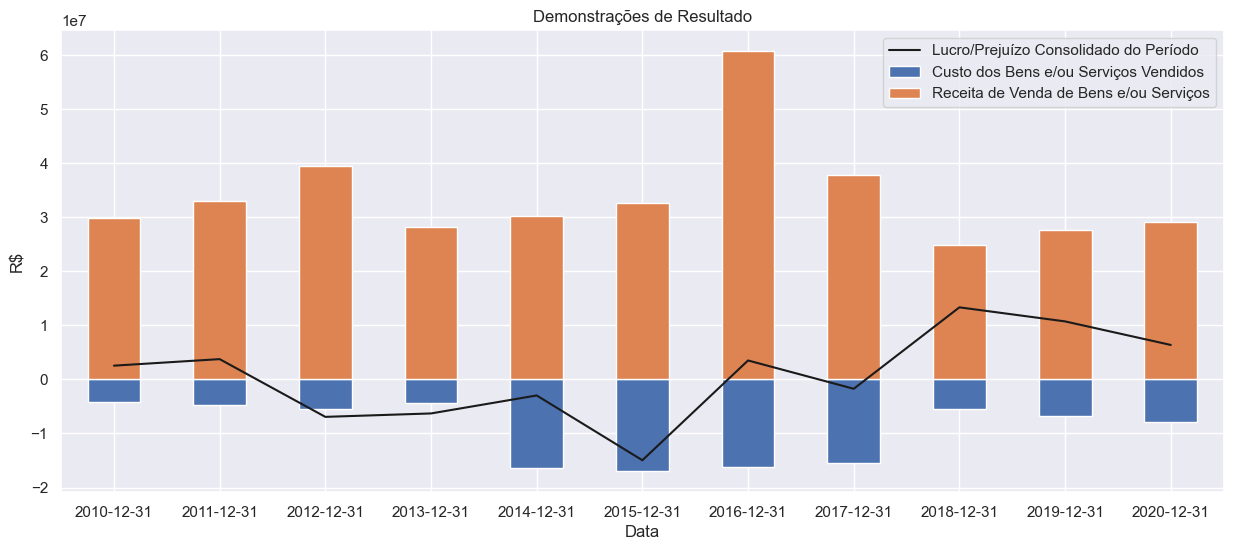

In [6]:
# Cria o gráfico da DRE
ax = sub_dre_pivot.drop('Lucro/Prejuízo Consolidado do Período', axis = 1).plot(kind = 'bar', stacked = True)
g = sub_dre_pivot[['Lucro/Prejuízo Consolidado do Período']].plot(ax = ax, color = 'k', figsize = (15, 6))

g.set(xlabel = 'Data', ylabel = 'R$', title = 'Demonstrações de Resultado')
g.legend(loc = 'best')

#### Analisando o ROE e o ROA

Criar indicadores é extremamente fácil usando os dados obtidos pelos demonstrativos no Python. Vejamos como calcular e visualizar os dados do Return on Equity e Return on Assets da Eletrobras.

<AxesSubplot: title={'center': 'Return on Equity \n Eletrobras - Consolidado'}, ylabel='%'>

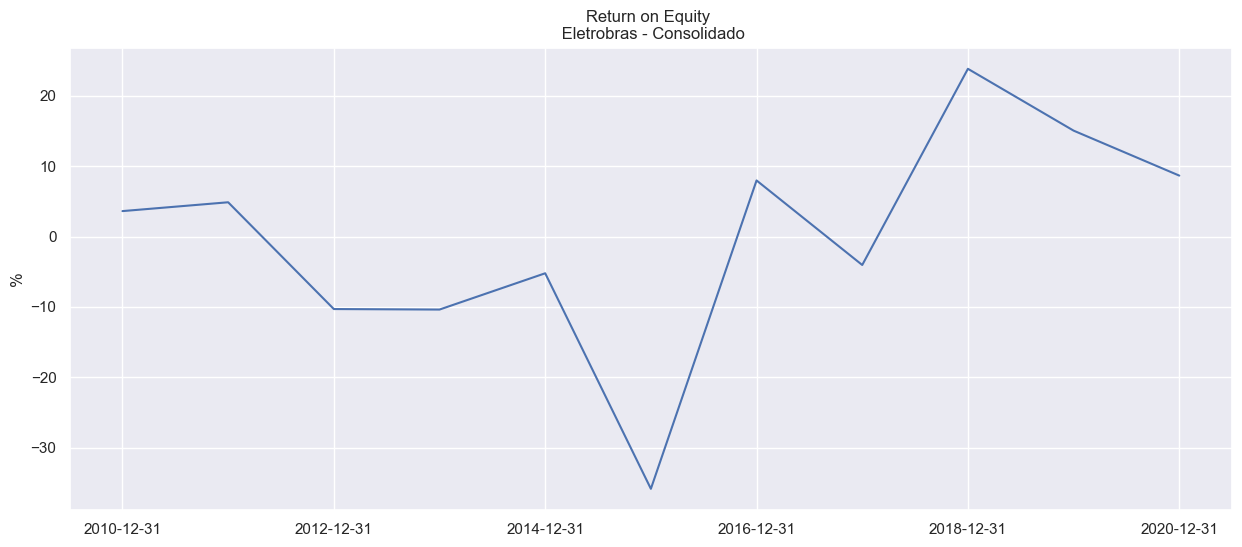

In [7]:
# Lucro Líquido
lucro_liq = new_dre[(new_dre.CD_CONTA == '3.11') & (new_dre.CD_CVM == 2437) & (new_dre.ORDEM_EXERC == 'ÚLTIMO')]

# Patrimônio Líquido
patr_liq = bpp[['CD_CVM', 'DT_REFER', 'CD_CONTA', 'DENOM_CIA', 'DS_CONTA', 'VL_CONTA']][(bpp.CD_CONTA == '2.03') & (bpp.CD_CVM == 2437) & (bpp.ORDEM_EXERC == 'ÚLTIMO')]

# Calcula o ROE
roe = lucro_liq.set_index('DT_REFER').VL_CONTA / patr_liq.set_index('DT_REFER').VL_CONTA

roe.multiply(100).plot(xlabel = '', ylabel = '%', title = 'Return on Equity \n Eletrobras - Consolidado', figsize = (15, 6))

<AxesSubplot: title={'center': 'Return on Asset \n Eletrobras - Consolidado'}, ylabel='%'>

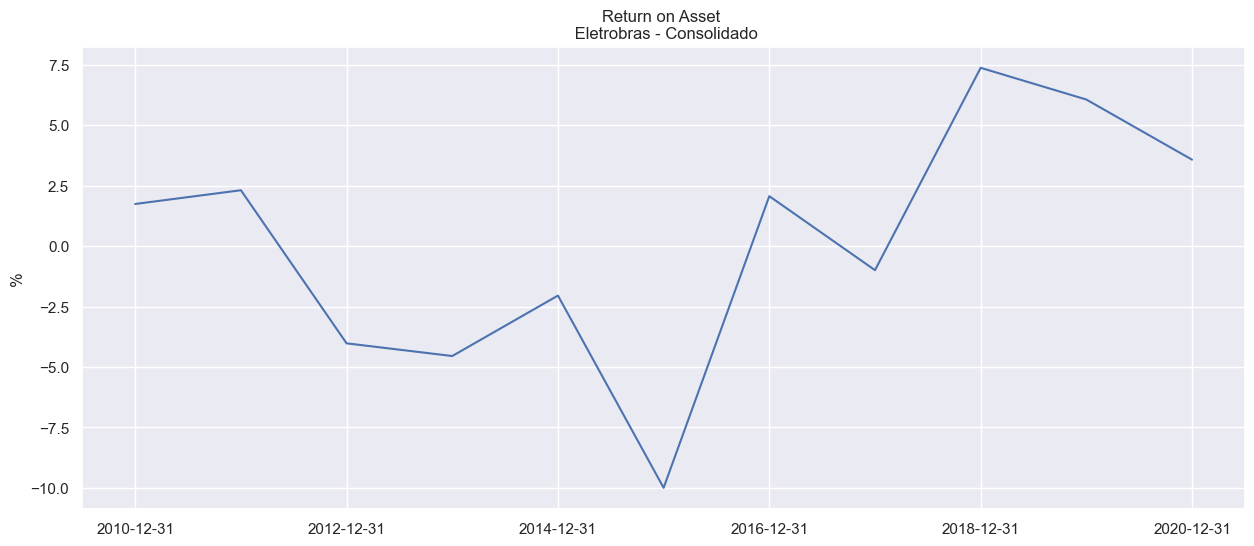

In [8]:
# Lucro Líquido
lucro_liq = new_dre[(new_dre.CD_CONTA == '3.11') & (new_dre.CD_CVM == 2437) & (new_dre.ORDEM_EXERC == 'ÚLTIMO')]

# Ativo Total
ativo_total = bpa[['CD_CVM', 'DT_REFER', 'CD_CONTA', 'DENOM_CIA', 'DS_CONTA', 'VL_CONTA']][(bpa.CD_CONTA == '1') & (bpa.CD_CVM == 2437) & (bpa.ORDEM_EXERC == 'ÚLTIMO')]

# Calcula o ROA
roa = lucro_liq.set_index('DT_REFER').VL_CONTA / ativo_total.set_index('DT_REFER').VL_CONTA

roa.multiply(100).plot(xlabel = '', ylabel = '%', title = 'Return on Asset \n Eletrobras - Consolidado', figsize = (15, 6))